In [2]:
import tensorflow as tf
import keras
import skimage.io
import numpy as np
import lime

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from matplotlib import pyplot as plt
from skimage.segmentation import mark_boundaries

print('Notebook running: tensorflow ', tf.__version__)
print('Notebook running: keras ', keras.__version__)
print('Notebook running: numpy ', np.__version__)

np.random.seed(0)

Notebook running: tensorflow  2.4.1
Notebook running: keras  2.4.3
Notebook running: numpy  1.19.5


It's possible to choose between VGG16, VGG19, MobileNet, InceptionV3(changing the img size) and the AkinolaVGG16. For this experiments ( recognizing chimpanzee, gorilla and white tiger) AkinolaVGG16 is the most accurate

In [3]:
#Load pretrained model 

from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
model = tf.keras.models.load_model('..\\data\\model')

# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions 
# model=VGG16()

# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
# model=VGG19()

# from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
# model=MobileNet()

# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
# model=InceptionV3()

In [4]:
model.summary()

Model: "AkinolaVGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [5]:
#loading image

img = tf.keras.preprocessing.image.load_img("..\\images\\image2.jpg", target_size=(224, 224))
# img = tf.keras.preprocessing.image.load_img("..\\images\\image2.jpg.jpg", target_size=(299, 299)) #Inception
img = np.array(img)


<function matplotlib.pyplot.show(close=None, block=None)>

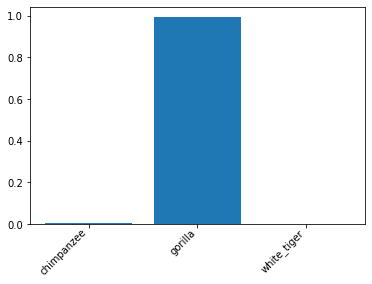

In [6]:
#making prediction
preds = np.round(model.predict(preprocess_input(np.expand_dims(img.copy(), axis=0))),5)
predict=[]

if (model.name=='AkinolaVGG16'):
    class_names={'0':'chimpanzee', '1':'gorilla','2':'white_tiger'}
    preds_data = dict(zip(class_names.values(), preds[0]))
else:
    decoded_preds=decode_predictions(preds,top=10)
    class_names={}
    ind =(-preds[0]).argsort()[:10]
    for i in range (10):
        class_names[str(ind[i])]=decoded_preds[0][i][1]
        predict.append(decoded_preds[0][i][2])
    preds_data = dict(zip(class_names.values(), predict))

#plot results
plt.bar(range(len(preds_data)), list(preds_data.values()), align='center')
plt.xticks(range(len(preds_data)), list(preds_data.keys()),rotation=45,va='center_baseline',horizontalalignment='right')
plt.show

In [7]:
#generate superpixels

kernel_size=6
max_dist=10
ratio=0.0005
superpixels = skimage.segmentation.quickshift(img, kernel_size=kernel_size,max_dist=max_dist, ratio=ratio)
num_superpixels = np.unique(superpixels).shape[0]
print(num_superpixels)


36


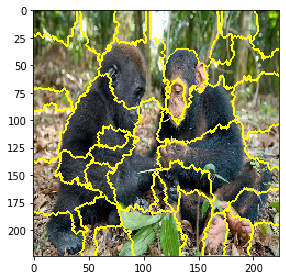

In [8]:
# show segmented image

skimage.io.imshow(skimage.segmentation.mark_boundaries(img/255, superpixels));

In [8]:
#set segmentation function

seg_fn=SegmentationAlgorithm('quickshift', kernel_size=kernel_size,max_dist=max_dist, ratio=ratio,random_seed=0)

In [9]:
#setting lime as explainier

explainer = lime_image.LimeImageExplainer()

In [10]:
def class_fn(img):
    return model.predict(preprocess_input(img))

In [11]:
#getting explanation

explanation = explainer.explain_instance(img,class_fn,top_labels=4, hide_color=None, num_samples=800,segmentation_fn=seg_fn,num_features=num_superpixels)

100%|██████████| 800/800 [00:22<00:00, 35.96it/s]


In [12]:
def explanation_ind(ind):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[ind], positive_only=True, num_features=5, hide_rest=True)
    axes[0].set_title("Explanation for the "+class_names[str(explanation.top_labels[ind])]+" probabilities")
    axes[0].axis("off")
    axes[0].imshow(mark_boundaries(temp/255, mask));

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[ind], positive_only=False, num_features=20, hide_rest=False,min_weight=0.005)
    axes[1].set_title("Pros and cons for the "+class_names[str(explanation.top_labels[ind])]+" probabilities")
    axes[1].axis("off")
    axes[1].imshow(mark_boundaries(temp/255, mask));

    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[explanation.top_labels[ind]])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    axes[2].set_title("Heat map of the "+class_names[str(explanation.top_labels[ind])]+" probabilities")
    axes[2].axis("off")
    asd=plt.imshow(heatmap.astype('float'), cmap = 'RdBu', vmin  = -0.5, vmax =0.5 )
    fig.colorbar(asd)


Plot are sorted in descending order of probabilities 

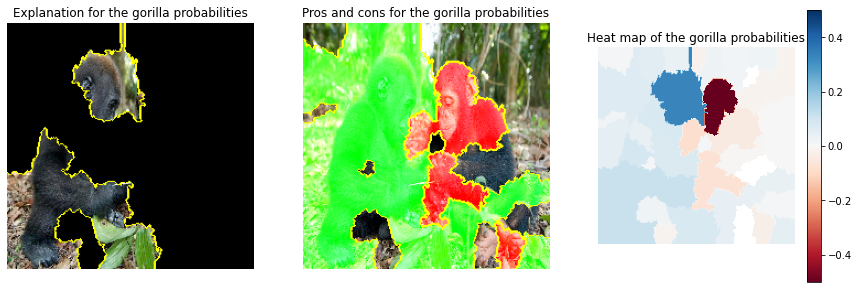

In [14]:
explanation_ind(0)

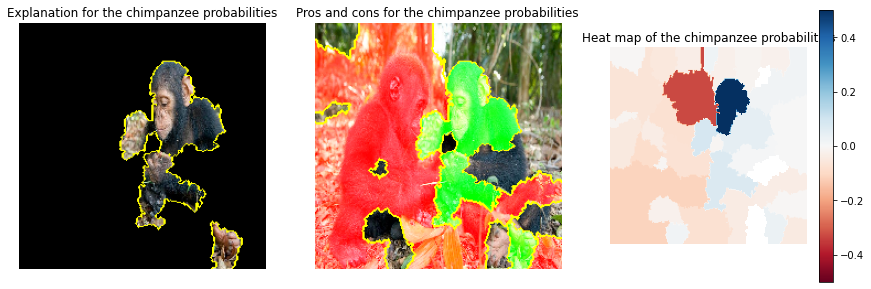

In [15]:
explanation_ind(1)

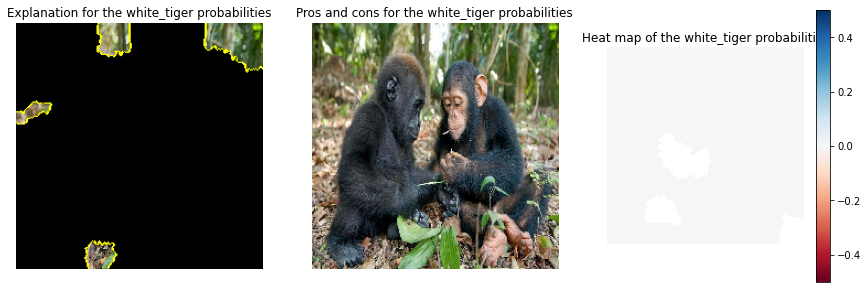

In [16]:
explanation_ind(2)